In [1]:
# 이 셀은 무시하셔도 됩니다

import tensorflow as tf
 
 
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()    # mnist data import

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # CAM을 구현하기 위해 Conv2D, GlobalMaxPooling2D, Dense 추가
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(10, activation='softmax'),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 19,466
Trainable params: 19,466
Non-trainable params: 0
_________________________________________________________________


In [5]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 1s 3ms/step - loss: 0.8407 - accuracy: 0.7848 - val_loss: 0.2527 - val_accuracy: 0.9260
Epoch 2/15
422/422 [==============================] - 1s 3ms/step - loss: 0.2237 - accuracy: 0.9338 - val_loss: 0.1655 - val_accuracy: 0.9492
Epoch 3/15
422/422 [==============================] - 1s 3ms/step - loss: 0.1652 - accuracy: 0.9486 - val_loss: 0.1345 - val_accuracy: 0.9605
Epoch 4/15
422/422 [==============================] - 1s 3ms/step - loss: 0.1358 - accuracy: 0.9586 - val_loss: 0.1216 - val_accuracy: 0.9623
Epoch 5/15
422/422 [==============================] - 1s 3ms/step - loss: 0.1172 - accuracy: 0.9631 - val_loss: 0.1097 - val_accuracy: 0.9653
Epoch 6/15
422/422 [==============================] - 1s 3ms/step - loss: 0.1057 - accuracy: 0.9670 - val_loss: 0.0947 - val_accuracy: 0.9695
Epoch 7/15
422/422 [==============================] - 1s 3ms/step - loss: 0.0960 - accuracy: 0.9694 - val_loss: 0.0880 - val_accuracy: 0.9717
Epoch 

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.06933323293924332
Test accuracy: 0.978600025177002


In [7]:
# 참고
# https://dryjelly.tistory.com/147
# https://github.com/jacobgil/keras-cam/blob/master/cam.py

import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
%matplotlib inline

get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])    # 이미지 입력을 받아 model의 마지막에 추가한 Conv2D와 Dense 레이어를 출력하는 모델
[conv_outputs, predictions] = get_output(np.array([x_test[0]]))                # 이미지 입력
conv_outputs = conv_outputs[0, :, :, :]

class_weights = model.layers[-1].get_weights()[0]    # model의 맨 마지막 레이어인 Dense 레이어의 weight를 가져온다

cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
for i, w in enumerate(class_weights[:, 1]):
        cam += w * conv_outputs[:, :, i]    # 마지막 레이어의 각 가중치와 Conv2D의 결과를 곱하여 누적하여 가산 -> CAM 구

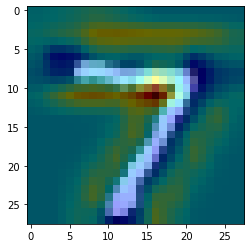

In [8]:
# 결과 이미지를 보기 좋게 가공

# CAM 이미지의 값 범위를 0 부터 255까지로 맞추고
# 이미지 크기를 원본 데이터와 일치하도록 resize한다
heatmap = cam
heatmap = heatmap / (np.max(heatmap) - np.min(heatmap)) * 255.9
heatmap = np.uint8(heatmap - np.min(heatmap))
heatmap = cv2.resize(heatmap, (28, 28))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 원본 이미지도 비슷하게 처리
origin_img = np.reshape(x_test[0], (28, 28))
origin_img = origin_img / (np.max(origin_img) - np.min(origin_img)) * 255.9
origin_img = np.uint8(origin_img - np.min(origin_img))
origin_img = cv2.merge((origin_img,origin_img,origin_img))

# 원본 이미지와 CAM 합성
a = 0.6
dst = cv2.addWeighted(origin_img, a, heatmap, 1 - a, 0)
plt.imshow(dst)